In [15]:
import math
import os
import cv2
import numpy as np
from PIL import Image
from enum import Enum
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import savgol_filter


In [16]:
def zero_pad(Y):
    mx, my = Y.shape
    padded_x = ((mx + 7) // 8) * 8
    padded_y = ((my + 7) // 8) * 8
    img = np.zeros((padded_x, padded_y), dtype=np.uint8)
    img[:mx, :my] = Y

    return img

def DCT(img):
    w, h = img.shape
    num_blocks = (w // 8) * (h // 8)
    dct_output = np.zeros((8, 8, num_blocks), dtype=float)

    for ci, (i, j) in enumerate((x, y) for x in range(0, w, 8) for y in range(0, h, 8)):
        dct_output[:, :, ci] = cv2.dct(img[i:i+8, j:j+8].astype(np.float32))  # Ensure input is float for DCT

    return dct_output


def hist(DC, N=2000, show=False):
    hcount, bin_edges = np.histogram(DC, bins=N, density=True)
    if show:
        plt.figure(figsize=(10, 6))
        sns.histplot(x=bin_edges[:-1], weights=hcount, bins=N, kde=True, stat="density")
        plt.title("DC Coefficient Histogram")
        plt.xlabel("DC Coefficient Value")
        plt.ylabel("Density")
        plt.show()
    return hcount, bin_edges

def FFT(hcount):
  hcount -= np.mean(hcount)
  x = np.fft.fft(hcount.astype(float))
  x = abs(np.fft.fftshift(x))
  x = savgol_filter(x, 11, 2)
  return x

def quality(x, N=2000):
    ref = np.max(x)*0.15+np.mean(x)
    #ref += 0.065
    peaks, _ = find_peaks(x, height=ref, distance=15)
    uncompressed = False
    avg_dist = 0
    if len(peaks) <= 1:
        uncompressed = True
    else:
        distances = np.diff(peaks)
        avg_dist = np.bincount(distances).argmax()

    #print("Most Frequent Distance:", avg_dist if len(peaks) > 1 else "N/A")
    return uncompressed, avg_dist, peaks


In [17]:
'''
# Generating training data
uncompressed_data = []
quality_high = []
quality_medium = []
quality_low = []

image_number = 50 # 800 to account for the fact that it's counting from 1

for i in range(0, image_number):
    for j in range(1, 5):              # each image has 4 versions
        file_name = f"{i + 1:04}x4w{j}.png"
        path = os.path.join("./DIV2K_train_LR_wild", file_name)
        
        img = compress(path, QualityLevel.ORIGINAL)

        img = img.convert('YCbCr')
        img = zero_pad(np.array(img)[:,:,0])
        img = img.astype(np.float64)
        dct = DCT(img)[0,0,:]
        hcount, bin_edges = hist(dct)
        fft = FFT(hcount)
        _, avg_peak_dist = quality(fft)
        uncompressed_data.append(avg_peak_dist)
        
# High-quality images
for i in range(0, image_number):
    for j in range(1, 5):
        file_name = f"{i + 1:04}x4w{j}.png"
        
        path = os.path.join("DIV2K_train_LR_wild", file_name)
        
        img = compress(path, QualityLevel.HIGH)
        img = img.convert('YCbCr')
        img = zero_pad(np.array(img)[:,:,0])
        img = img.astype(np.float64)
        dct = DCT(img)[0,0,:]
        hcount, bin_edges = hist(dct)
        fft = FFT(hcount)
        _, avg_peak_dist = quality(fft)
        quality_high.append(avg_peak_dist)

# Medium-quality images
for i in range(0, image_number):
    for j in range(1, 5):
        file_name = f"{i + 1:04}x4w{j}.png"
        path = os.path.join("DIV2K_train_LR_wild", file_name)
        
        img = compress(path, QualityLevel.MEDIUM)
        img = img.convert('YCbCr')
        img = zero_pad(np.array(img)[:,:,0])
        img = img.astype(np.float64)
        dct = DCT(img)[0,0,:]
        hcount, bin_edges = hist(dct)
        fft = FFT(hcount)
        _, avg_peak_dist = quality(fft)
        quality_medium.append(avg_peak_dist)

img = compress("DIV2K_train_LR_wild/0001x4w1.png", 90)
img = img.convert('YCbCr')
img = zero_pad(np.array(img)[:,:,0])
img = img.astype(np.float64)
dct = DCT(img)[0,0,:]
hcount, bin_edges = hist(dct)
fft = FFT(hcount)
print(quality(fft))

_,_,peaks= quality(fft)

fig = plt.figure(figsize=(20,8))
plt.plot(hcount)
fig.suptitle("Histogram of DC Term",fontsize=20)


plt.figure(figsize=(20, 8))
plt.plot(fft)
plt.plot(peaks, fft[peaks], marker='s')
plt.title("FFT of DC Coefficient Histogram")
plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")
plt.show()
'''

'\n# Generating training data\nuncompressed_data = []\nquality_high = []\nquality_medium = []\nquality_low = []\n\nimage_number = 50 # 800 to account for the fact that it\'s counting from 1\n\nfor i in range(0, image_number):\n    for j in range(1, 5):              # each image has 4 versions\n        file_name = f"{i + 1:04}x4w{j}.png"\n        path = os.path.join("./DIV2K_train_LR_wild", file_name)\n        \n        img = compress(path, QualityLevel.ORIGINAL)\n\n        img = img.convert(\'YCbCr\')\n        img = zero_pad(np.array(img)[:,:,0])\n        img = img.astype(np.float64)\n        dct = DCT(img)[0,0,:]\n        hcount, bin_edges = hist(dct)\n        fft = FFT(hcount)\n        _, avg_peak_dist = quality(fft)\n        uncompressed_data.append(avg_peak_dist)\n        \n# High-quality images\nfor i in range(0, image_number):\n    for j in range(1, 5):\n        file_name = f"{i + 1:04}x4w{j}.png"\n        \n        path = os.path.join("DIV2K_train_LR_wild", file_name)\n        \

In [18]:
def compress(path, quality=100):
    img = Image.open(path)
    img = img.convert('RGB')
    img.save('temp_jpeg.jpg',quality = quality)
    return Image.open("temp_jpeg.jpg")

# Generating training data
image_number = 800 # number of images
quality_peak_list=[]

for q in range(10,101,10):
    l=[]
    print(q)
    for i in range(0, image_number):              # each image has 4 versions
        file_name = f"{i + 1:04}x4w1.png"
        path = os.path.join("./DIV2K_train_LR_wild", file_name)
        
        img = compress(path, q)

        img = img.convert('YCbCr')
        img = zero_pad(np.array(img)[:,:,0])
        img = img.astype(np.float64)
        dct = DCT(img)[0,0,:]
        hcount, bin_edges = hist(dct)
        fft = FFT(hcount)
        _, avg_peak_dist,_ = quality(fft)
        l.append(avg_peak_dist)
    quality_peak_list.append(l)

10
20
30
40
50
60
70
80
90
100


[[ 84. 206. 457.  43.   4.   1.   0.   1.   0.   0.   0.   1.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   3.]
 [ 89. 206. 457.  46.  12.  65. 272. 423.  20.   0.   1.   1.   1.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   7.]
 [100. 209. 460.  54.  13.  66. 273. 436. 106. 365. 304.   2.   1.   0.
    1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.  10.]
 [106. 210. 463.  55.  15.  68. 277. 441. 108. 374. 373. 327. 359.   6.
    1.   0.   2.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.  13.]
 [131. 219. 467.  55.  21.  71. 296. 441. 108. 376. 377. 344. 501. 419.
  151.   0.   2.   3.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.  17.]
 [158. 225. 471.  60.  21.  72. 296. 442. 112. 390. 395. 345. 512. 481.
  416. 365.  11.   3.   2.   0.   2.   0.   0.   0.   0.   0.   0.   0.
    0.  21.]
 [205. 236. 474.  68.  24.  85. 298. 443. 113. 393. 399. 3

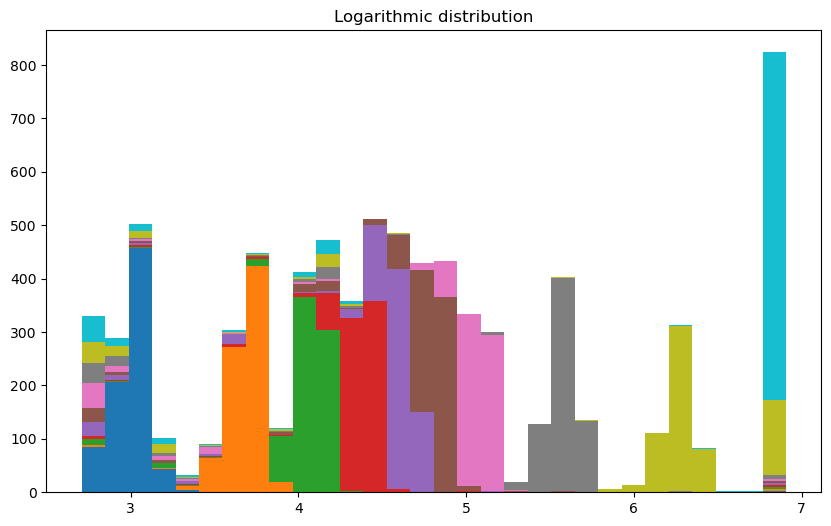

9

In [19]:
def find_bin(avg_dist):
    return np.digitize(logaritmare(avg_dist),bins)

def logaritmare(x):
    if x==0:
        x=1000
    return math.log(x)

vfunc = np.vectorize(logaritmare)

X=[np.array(vfunc(x)) for x in quality_peak_list]

plt.figure(figsize=(10, 6))

nb,bins,_ = plt.hist(X,bins=30, stacked=True ,histtype='bar',cumulative=False)

#floating point error: when an image gets a value exactly at the boundary, floating point precision might cause it to overshoot the bin
bins[-1]+=1
bins[0]-=1

print(nb)
print(bins)

#plt.hist(original_values,density=True, histtype='bar', stacked=True)
#plt.hist(high_values,density=True, histtype='bar', stacked=True)
#plt.hist(medium_values,density=True, histtype='bar', stacked=True)
#plt.hist(low_values,density=True, histtype='bar', stacked=True)
plt.title("Logarithmic distribution")
plt.xlabel("")
plt.ylabel("")
plt.show()


def most_likely_category(avg_dist):
    # when I get a new image see which bin it is in
    # P(cat1| bin x) = P(binx|cat1)*P(cat1) / P(binx)
    # greatest prob wins
    # p1 = nr_binx_cat1/nr_cat1 * nr_cat1/ nr_all_cat / nr_binx_total * nr_all_cat
    # p1 = nr_binx_cat1/nr_binx_total
    # since nr_binx_total is the same for all probabilities, we can just compare the number of images in each bin
    bin=find_bin(avg_dist)
    candidate_bin = nb[0][bin-1]
    ind=0
    for i in range(1,10):
        if nb[i][bin-1]-nb[i-1][bin-1] > candidate_bin:
            candidate_bin = nb[i][bin-1]-nb[i-1][bin-1]
            ind=i
    return ind+1
    
most_likely_category(400)

In [20]:
number_of_tests = 100
testing_cutoff = 700 # images from 700 onwards are for testing

error=0

for i in range(0, number_of_tests):
        for j in range(1, 5):
            
            file_name = f"{testing_cutoff + i + 1:04}x4w1.png"
            path = os.path.join("DIV2K_train_LR_wild", file_name)
            
            qual_cat = np.random.randint(1,11)
        
            img = compress(path, qual_cat*10)
            img = img.convert('YCbCr')
            img = zero_pad(np.array(img)[:,:,0])
            img = img.astype(np.float64)
            dct = DCT(img)[0,0,:]
            hcount, bin_edges = hist(dct)
            fft = FFT(hcount)
            _, avg_peak_dist,_ = quality(fft)
            print(avg_peak_dist)
            cat=most_likely_category(avg_peak_dist)
            print(qual_cat*10, cat*10)
            error += np.abs(cat*10-qual_cat*10)
            
            
print(f"average error: {error / number_of_tests} ")

85
40 40
63
30 30
568
90 90
43
20 20
37
20 20
245
80 80
73
40 40
18
10 10
0
100 100
301
80 80
181
70 70
112
50 60
0
100 100
81
50 40
0
100 100
217
80 80
19
10 10
19
10 10
94
50 50
94
50 50
129
60 60
280
80 80
106
50 50
559
90 90
101
50 50
101
50 50
269
80 80
20
10 10
0
100 100
45
20 20
45
20 20
22
10 10
467
90 90
52
30 30
233
80 80
108
60 60
61
30 30
547
90 90
82
40 40
102
50 50
128
60 60
16
70 10
29
100 20
29
90 20
54
30 30
54
30 30
246
80 80
491
90 90
33
20 20
444
90 90
33
20 20
222
80 80
0
100 100
232
80 80
106
60 50
463
90 90
125
60 60
0
100 100
540
90 90
80
40 40
126
60 60
102
50 50
21
10 10
0
90 100
60
30 30
15
50 10
19
70 10
15
50 10
26
70 10
25
100 10
16
50 10
25
100 10
121
60 60
23
90 10
23
100 10
20
10 10
528
90 90
20
10 10
79
40 40
265
80 80
63
30 30
170
70 70
170
70 70
42
20 20
19
10 10
0
90 100
92
50 40
92
50 40
0
100 100
67
30 30
89
40 40
67
30 30
0
100 100
525
90 90
0
100 100
525
90 90
77
40 40
58
30 30
0
100 100
96
50 50
141
70 70
0
100 100
52
30 30
52
30 30
293
80 80
8

In [21]:
print(bins)
print(np.digitize(logaritmare(0),bins))
print(logaritmare(0))

[1.7080502  2.84804037 2.98803054 3.12802071 3.26801088 3.40800105
 3.54799122 3.68798139 3.82797156 3.96796172 4.10795189 4.24794206
 4.38793223 4.5279224  4.66791257 4.80790274 4.94789291 5.08788308
 5.22787325 5.36786342 5.50785359 5.64784376 5.78783392 5.92782409
 6.06781426 6.20780443 6.3477946  6.48778477 6.62777494 6.76776511
 7.90775528]
30
6.907755278982137
